## Suitability Analysis of Optimal Locations for Planting Trees in San Diego
**By**: Eric Yu, Justin Lu <br> <br>
Project for Spatial Data Science and Applications course (DSC 170 - UC San Diego)

# 1. Formulate a suitability model


Our suitability model investigates and selects the optimal locations to plant trees in the city of San Diego. We wanted to tackle this issue because we believe that trees are an important part of the ecosystem and many natural environmental cycles. They reduce air pollutants and stormwater run-off (because of its heavy requirement of water), offset carbon imbalances in the atmosphere caused by pollutants, and simply provide welcome shade for residents, among many other benefits. Because of this, we believe that it is important for the city to plant trees wherever and whenever possible, in order to make the city more livable and pleasant for its citizens. 

Our pipeline evaluates and weighs the relative importance of several raster layers that indicate soil quality (i.e. erosion), amount of precipitation, and water drainage in the soil. We want to search for areas that accommodate the right soils for trees that promote the conditions stated above (oak trees, pine trees) and have proper conditions (rain, soil drainage) that optimize tree growth.

Submodels:
* **Environmental:** Soil erosion, precipitation
* **Built/Infrastructure:** Drainage

# 2. Imports, etc.

In [1]:
import pandas as pd
import numpy as np
import arcgis
from arcgis.gis import GIS
import arcgis.raster
from arcgis.raster.functions import *
from arcgis.geocoding import geocode

In [2]:
gis = GIS("home")

In [3]:
agol = GIS(username="admin")

Enter password: ········


# 3. Imagery Layers

In [4]:
soil_erodibility = ImageryLayer('https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erodibility_Factor/ImageServer', agol)

precipitation = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Rainfall/ImageServer", agol)

drainage = ImageryLayer('https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Drainage_Class/ImageServer', agol)

In [5]:
sd_extent = {'xmin': -13094557.355805734,
             'ymin': 3784318.1780585,
             'xmax': -12899970.885899095,
             'ymax': 4016441.778412193}
sd_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})
sd_extent

{'xmin': -13094557.355805734,
 'ymin': 3784318.1780585,
 'xmax': -12899970.885899095,
 'ymax': 4016441.778412193,
 'spatialReference': {'latestwkid': 3857, 'wkid': 102100}}

# 4. Area of Interest (AOI)

In [6]:
precipitation.extent = sd_extent

soil_erodibility.extent = sd_extent

drainage.extent = sd_extent

<Item title:"USA Counties (Generalized)" type:Feature Layer Collection owner:esri_livingatlas>
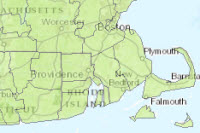

In [7]:
counties = gis.content.get('f7ea0c30856b4ef9a00d07978426f4d4')
counties

# 5. Combination Techniques

### Contributory (weighted overlay) 
The contributory map combination method assigns weights to each map that we want to combine, then performs a linear sum of these maps into one map layer <br>

**Pros:** This method takes all factors that we chose for our analysis into account. The final combined map is a "mix" of all the factors and their values in the San Diego area. This is helpful because our problem is multi-faceted; many factors contribute to a decision to plant greenery in the city. <br>
**Cons:** Since this combination takes weights for each factor, the choice of these weights is an issue. We may not be 100% sure of the weights of each of the factors we chose and exactly how important each of the factors are. <br>

### Exclusionary screening (binary)
The exclusionary screening/binary method assigns whether or not something is suitable (1 or 0), and a single instance of a 0 automatically (regardless of the value of the other variables) assigns the value 0. <br>

**Pros:** The output of the map's analysis is more concrete. This method ensures that all features that we define are represented and high in value (and therefore on the "good" side of the spectrum). We can be sure that the resulting map that is outputted consists only of areas that are perfectly suitable (in terms of our features). <br>
**Cons:** Since we are multiplying factors, a raster cell appears only if all values are non-zero. Therefore, even if an area has good soil erodibility/drainage (for example), if the model classifies that an area has low rainfall, the combined map may not register this and will just output that the area is not suitable for tree planting. This is a consequence of the "One Strike and You Are Out" phenomenon; there is no "middle ground" or gray area for the factors, because this method ensures that all features in the analysis are present.



# 6. Clipping Input Layers to AOI

In [8]:
layers = counties.layers[0]
sd_query = layers.query("FIPS='06073'", return_geometry=True)
sd_geom = sd_query.features[0].geometry
sd_geom['spatialReference'] = sd_query.spatial_reference

In [9]:
# Soil erodibility (susceptibility of soil to erode), ranges 3 - 49
erosion_clip = clip(raster=soil_erodibility, geometry=sd_geom) 
erosion_map = agol.map()
erosion_map.add_layer(erosion_clip)
erosion_map.legend = True
erosion_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [10]:
# Rain in inches, 1971 - 2009, ranges 3 - 35
prec_clip = clip(raster=precipitation, geometry=sd_geom)
prec_map = agol.map()
prec_map.add_layer(prec_clip)
prec_map.legend = True
prec_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [11]:
# Drainage (rate at which water drains in soil), ranges 0 - 5
drain_clip = clip(raster=drainage, geometry=sd_geom)
drain_map = agol.map()
drain_map.add_layer(drain_clip)
drain_map.legend = True
drain_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [12]:
a = np.array_split(range(3, 50), 5) # erosion range
b = np.array_split(range(3, 36), 5) # precipitation range
c = np.array_split(range(1, 6), 5) # drainage range
output = list(range(1, 6))[::-1]

### Determining Ranges
We defined a function below to approximate the ranges we would perform our calculations. We decided on 5 outputs for the normalization stage (the drainage raster values are between 1-5) and used Numpy to split the values into 5 distinct ranges.

In [13]:
# User defined function for determining ranges
def create_ranges(lst):
    res = []
    if len(lst[0]) != 1:
        res.append(lst[0][0])
        for i in range(4):
            res.append(lst[i][-1])
            res.append(lst[i][-1])
        res.append(lst[-1][-1])
    else:
        res.append(lst[0][0])
        for i in range(1, 4):
            res.append(lst[i][-1])
            res.append(lst[i][-1])
        res.append(lst[-1][-1])
    return list(np.array(res).astype(float))

In [14]:
erosion_range = create_ranges(a)
prec_range = create_ranges(b)
drain_range = create_ranges(c) + [5.0, 6.0]
output = list(range(1, 6))[::-1]
output # Normalize to 5 output values, 5 being the best, 1 being the worst

[5, 4, 3, 2, 1]

# 7a. Composite Raster Layer 1 (Weighted overlay)

In [15]:
# 7a. Generate a composite raster layer for your first map combination technique
erosion_norm = remap(erosion_clip, input_ranges = erosion_range, output_values = output, astype = 'U8')

prec_norm = remap(prec_clip, input_ranges = prec_range, output_values = output, astype = 'U8')

drain_norm = remap(drain_clip, input_ranges = drain_range, output_values = output, astype='U8')

cmap =  [[1, 64, 128, 0], [2, 128, 255, 0], [3, 255, 255, 0], [4, 255, 128, 0], [5, 255, 0, 0]] # Colors for representing different outputs, indices 1, 2, 3 represent R, G, B values

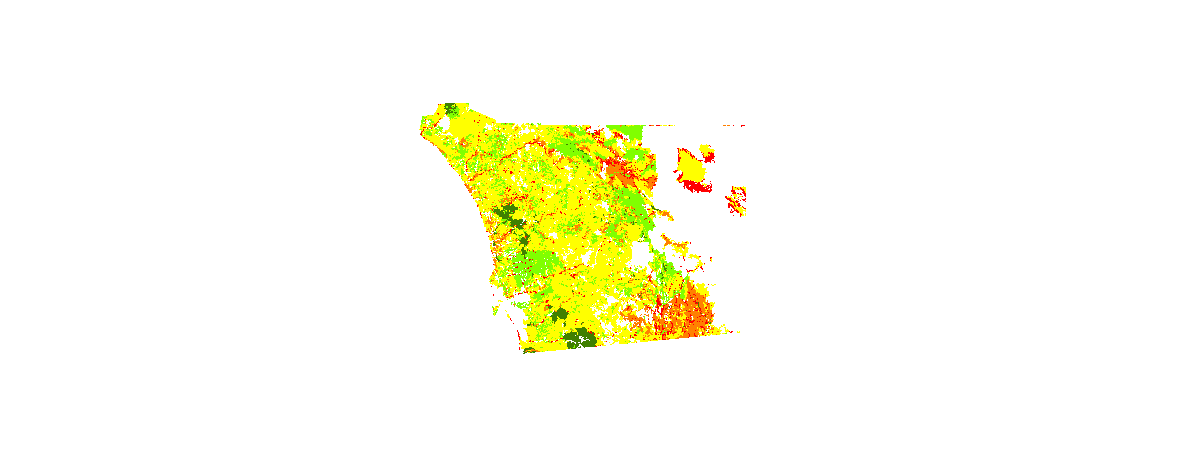

In [16]:
erosion_norm_color = colormap(erosion_norm, colormap = cmap)
erosion_norm_color

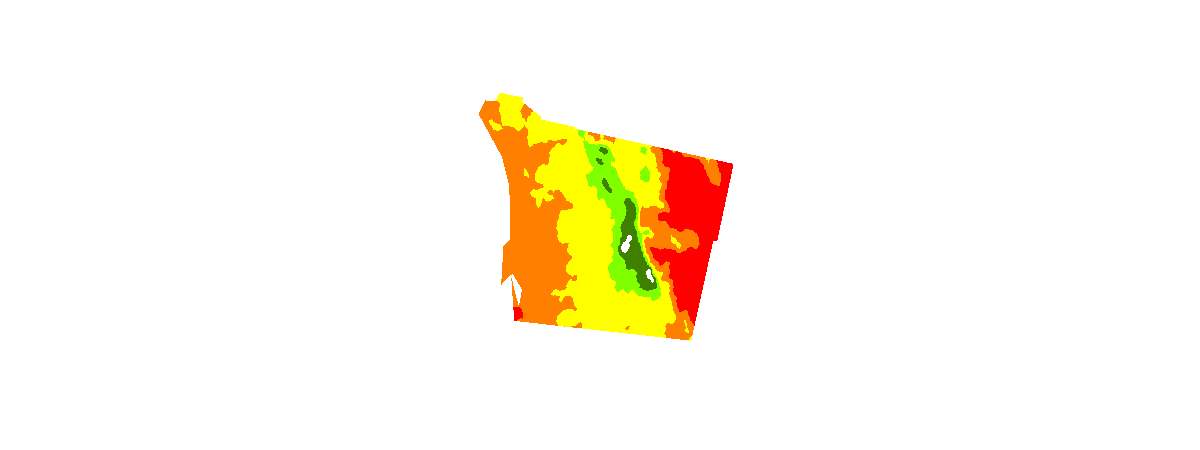

In [17]:
prec_norm_color = colormap(prec_norm, colormap = cmap)
prec_norm_color 

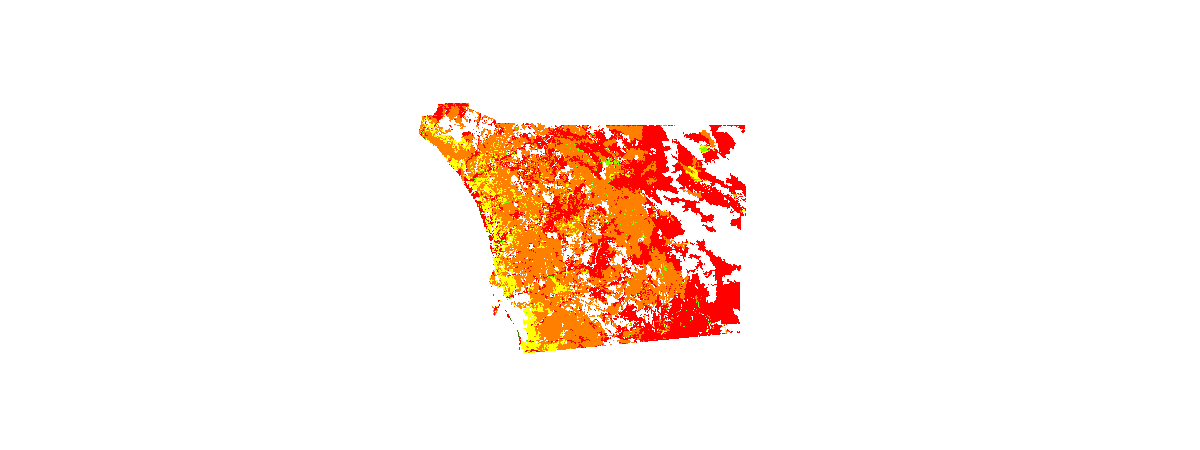

In [18]:
drain_norm_color = colormap(drain_norm, colormap = cmap)
drain_norm_color 

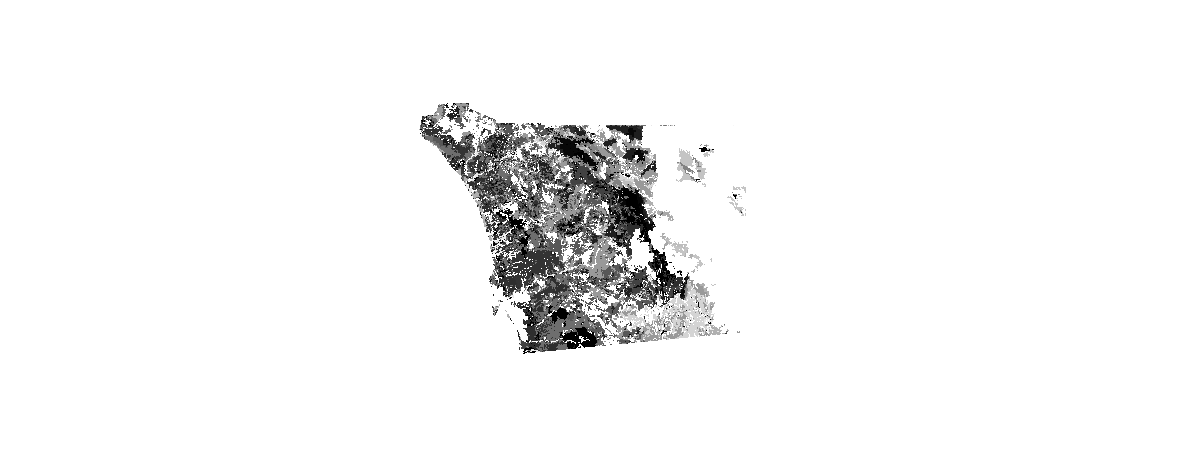

In [19]:
raster_output = raster_calculator(rasters = [erosion_norm, prec_norm, drain_norm], input_names = ["e","p","d"], expression = "e*.40 + p*.15 + d*.45", extent_type='FirstOf', cellsize_type='FirstOf', astype='none')
raster_output

In [20]:
weighted_ov = gis.content.get('e7387ef0d31b44eb86ff283a7079de49')
weighted_ov

<Item title:"Weighted_overlay_ey_jl" type:Imagery Layer owner:ery010_UCSDOnline>

In [21]:
wo_map = agol.map('San Diego')
wo_map.add_layer(weighted_ov)
wo_map.legend = True
wo_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

### Choosing weights to assign to factors
We chose the weights for the weighted overlay operation according to our own intuition about how important each factor was going to be for answering our query about the suitability of areas in San Diego for planting trees. Precipitation, to us, was considered the least important (but still impactful) because we believed that the amount of rainfall really should not vary very much in the county of San Diego, which is only about 4000 square miles. Although some areas of the county may have more rainfall than others, we did not place as much weight on the factor. In addition, even though new trees may need a lot of water, the more they grow, the lower the amount of watering is needed. What is more important for tree growth as time goes on is the amount of water in the soil, which we represented with the soil drainage class Imagery Layer. We assigned about equal weights to both soil drainage and soil erodibility. We found both of these features very important because the quality of soil is a significant factor of tree planting and growth. The soil cannot be dry, nor can it move easily and expose the tree’s roots. Therefore, we believed that the weights we set in our map combination best capture the areas for optimal tree growth. 


# 7b. Composite Raster Layer 2 (Binary/Exclusionary Screening)

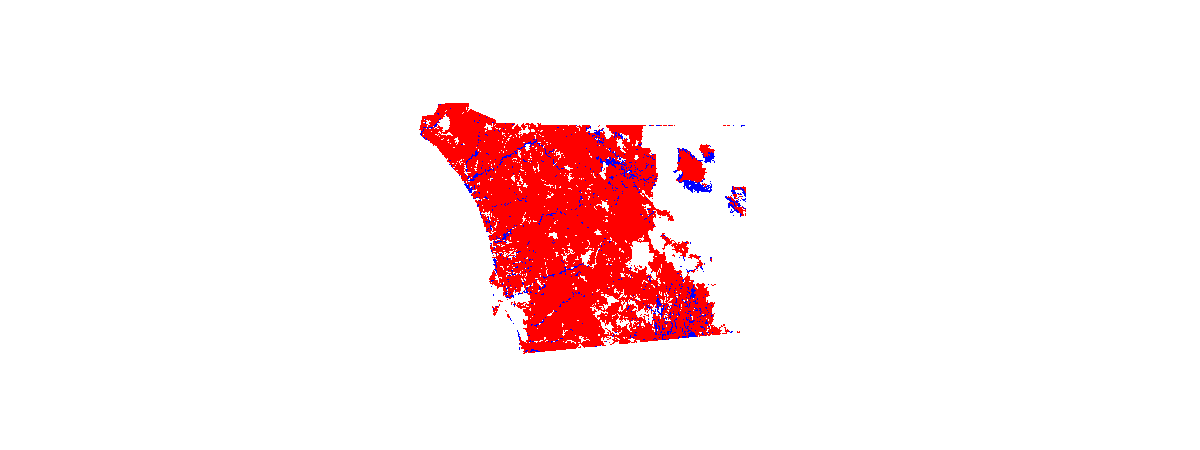

In [22]:
binary_color_map = [[1, 255, 0, 0], [0, 0, 0, 255]] # Red and blue

erosion_binar = remap(raster = erosion_clip, input_ranges = [3.0,15.0, 15.0,50.0], output_values = [0, 1], astype = 'U8')
erosion_binary_color = colormap(erosion_binar, colormap = binary_color_map)
erosion_binary_color

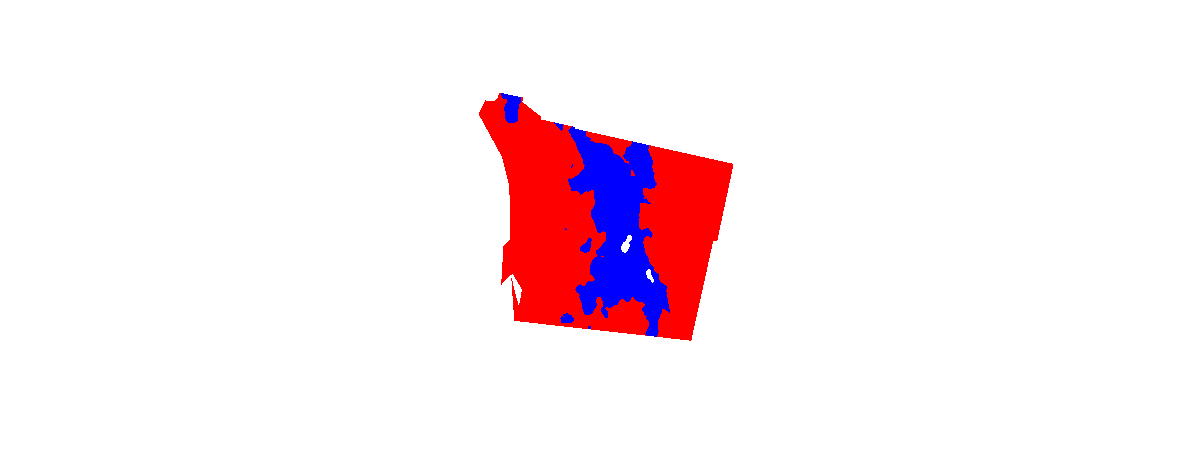

In [23]:
prec_binar = remap(raster = prec_clip, input_ranges = [3.0,19.0, 19.0,35.0], output_values = [1, 0], astype = 'U8')
prec_binary_color = colormap(prec_binar, colormap = binary_color_map)
prec_binary_color

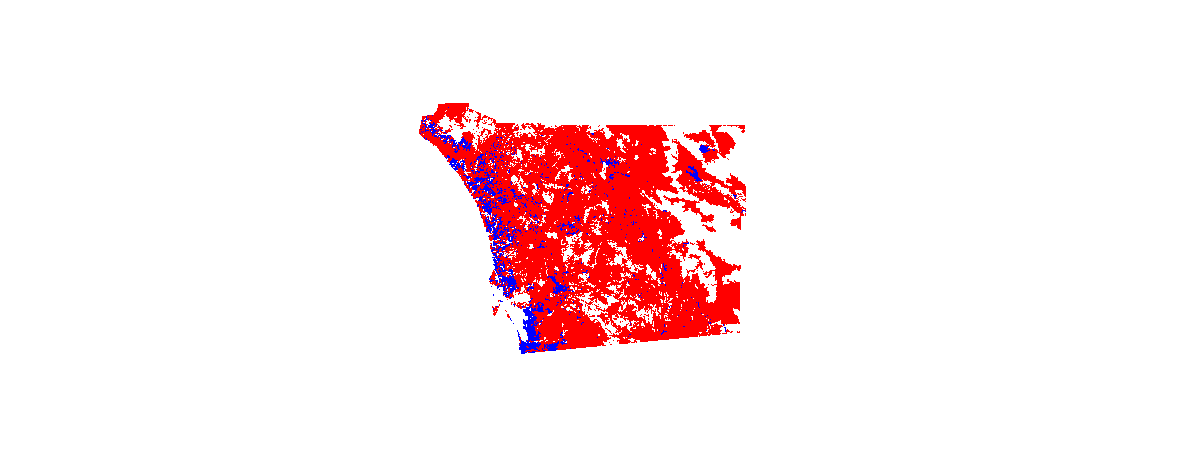

In [24]:
drain_binar = remap(raster = drain_clip, input_ranges = [1.0,3.0, 3.0,6.0], output_values = [1, 0], astype = 'U8')
drain_binary_color = colormap(drain_binar, colormap = binary_color_map)
drain_binary_color

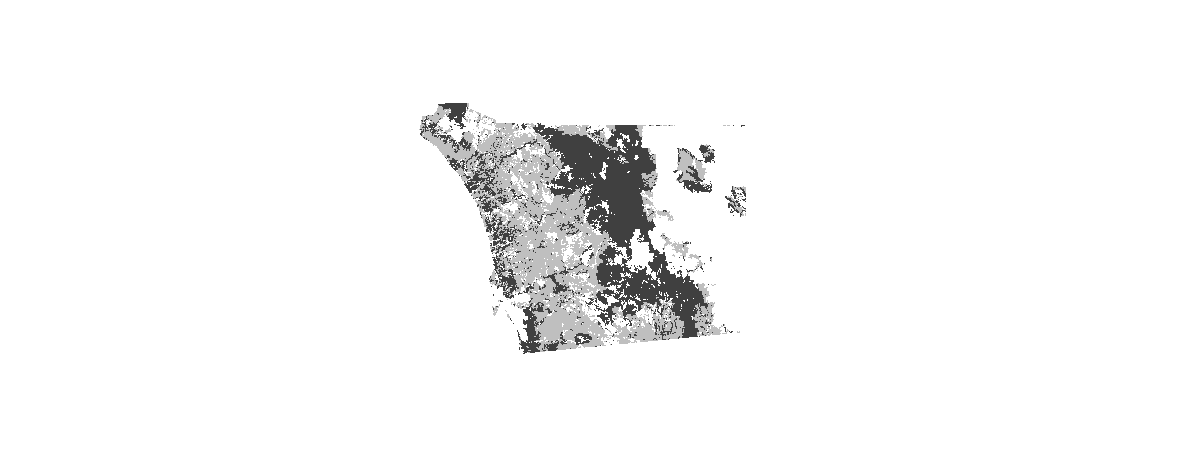

In [25]:
res_out_bin = arithmetic(erosion_binar, prec_binar, extent_type='FirstOf', cellsize_type='FirstOf', astype='none', operation_type=3)
res_out_bin_final = arithmetic(res_out_bin, drain_binar, extent_type='FirstOf', cellsize_type='FirstOf', astype='none', operation_type=3)
res_out_bin_final

In [26]:
binary_layer = gis.content.get('053f095051814e69a3127008737aeb52')
binary_layer

<Item title:"Binary_layer_ey_jl" type:Imagery Layer owner:ery010_UCSDOnline>

In [27]:
b_map = agol.map('San Diego')
b_map.add_layer(binary_layer)
b_map.legend = True
b_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

# 8. Summary of Results and Analysis



The two map combination techniques resulted in two different layers with slight differences. The areas of San Diego that the two analyses “shaded” and deemed as suitable for planting trees (our initial problem) ended up being the same areas of San Diego. For example, the resulting maps both did not suggest the land around the San Diego Airport as being suitable, which is expected. <br> 

The map that resulted from the weighted overlay (contributory) had more “shades” of black, implying a “level” to how suitable an area is for planting trees. Based on how we built the maps, the darker the shade of black over an area, the better the area is for planting trees (at least in terms of the factors we chose - precipitation, soil drainage and soil erodibility). This method gives us some “options” about what factors we choose for our final plan and what kind of “sacrifices” we can make in terms of where to plant the trees. Some areas may not be entirely suitable (maybe less precipitation or low soil drainage levels), but they will still be more suitable than other areas, and thus can be seen as viable options. <br>

As for the exclusionary screening method and the map it created, the difference between suitable areas and non-suitable areas was more black and white (literally). An area is either suitable or not (black or white). The exclusionary screening method comes up with a map that does not take makes sure all features are above a threshold value; otherwise, it is deemed not suitable. 

In summary, the weighted overlay technique shows us different levels of suitability, indicated by different shades of black and gray, whereas the exclusionary screening technique only indicates whether or not an area is suitable. The raster layers appear similar when zoomed out to the whole county of San Diego, but the differences in the shades of black and gray become apparent when zoomed into the geometry. 